# Get Dataset

In [1]:
# get imdb_cropped faces dataset
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

--2021-05-20 13:46:11--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar       100%[===================>]   6.53G  75.5MB/s    in 98s     

2021-05-20 13:47:50 (68.2 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]



In [2]:
# get wiki_cropped faces dataset
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

--2021-05-20 13:48:15--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  83.7MB/s    in 8.0s    

2021-05-20 13:48:23 (97.1 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



In [3]:
# extract data from .tar files
!tar -xf wiki_crop.tar
!tar -xf imdb_crop.tar

In [4]:
# remove .tar files
!rm *.tar

In [5]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [7]:
# get data paths
imdb_data_path = '/content/imdb_crop/'
wiki_data_path = '/content/wiki_crop/'
imdb_csv_path = '/content/drive/MyDrive/Colab Notebooks/dataset/imdb.csv'
wiki_csv_path = '/content/drive/MyDrive/Colab Notebooks/dataset/wiki.csv'

In [8]:
# read train and test data into dataframe
train_data = pd.read_csv(imdb_csv_path)
test_data = pd.read_csv(wiki_csv_path)

In [9]:
# preiew train data
train_data.head()

,full_path,age,gender
0,['01/nm0000001_rm946909184_1899-5-10_1968.jpg'],69,1
1,['01/nm0000001_rm980463616_1899-5-10_1968.jpg'],69,1
2,['02/nm0000002_rm1346607872_1924-9-16_2004.jpg'],80,0
3,['02/nm0000002_rm1363385088_1924-9-16_2004.jpg'],80,0
4,['02/nm0000002_rm221957120_1924-9-16_1974.jpg'],50,0


# Data Preprocessing

In [10]:
# format values of age and gender columns 
train_data['age'] = train_data['age'].apply(lambda x: str(x))
train_data['gender'] = train_data['gender'].apply(lambda x: str(int(x)))

test_data['age'] = test_data['age'].apply(lambda x: str(x))
test_data['gender'] = test_data['gender'].apply(lambda x: str(int(x)))

In [11]:
# format values of fullpath columns
train_data['full_path'] = train_data['full_path'].apply(lambda x: x[2:-2])
test_data['full_path'] = test_data['full_path'].apply(lambda x: x[2:-2])

In [12]:
# get gender dictionary
gender_dict = {'0': 'female', '1': 'male'}

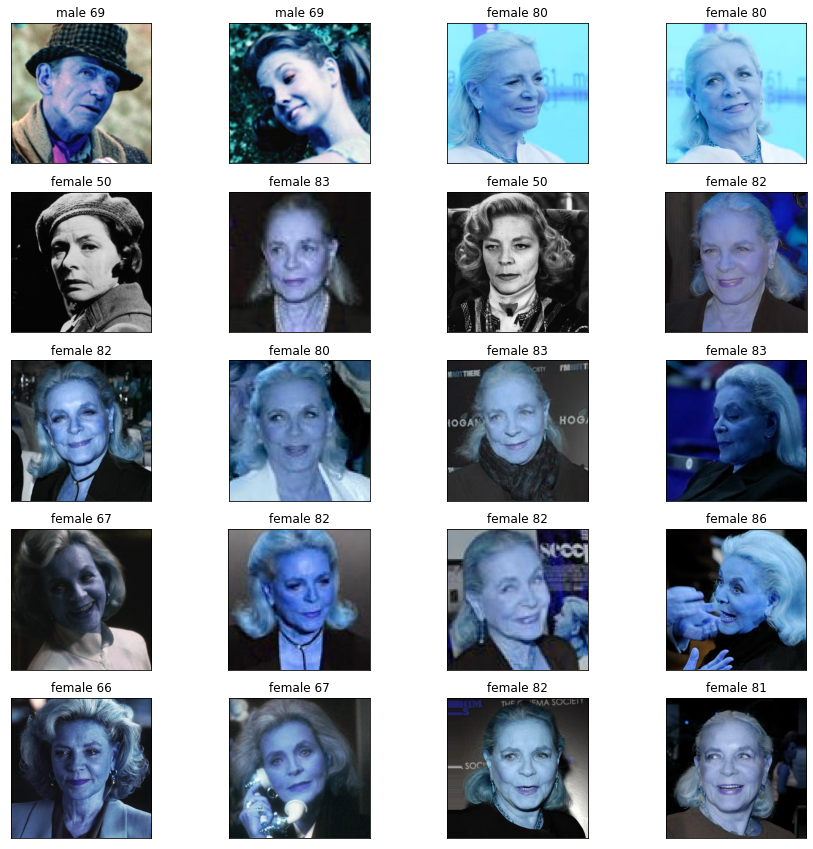

In [13]:
# plot sample images with age and gender
plt.figure(figsize= (15,15))
for i, path in enumerate((train_data['full_path'])[:20]):
  plt.subplot(5, 4, i+1)
  gender =  train_data['gender'][i]
  gender_name = gender_dict[gender]
  age = train_data['age'][i]
  abs_path = imdb_data_path + path
  img = cv2.imread(abs_path)
  plt.imshow(img)
  plt.title( gender_name + ' ' + age)
  plt.xticks([])
  plt.yticks([])
plt.show()

In [14]:
# split test data into validation and test sets
val_data, test_data = train_test_split(test_data, test_size= 0.4, random_state = 0)

In [16]:
# preview validation data
val_data.head()

,full_path,age,gender
37137,82/43964682_1984-05-31_2011.jpg,27,0
18326,87/164087_1938-05-08_2008.jpg,70,1
20236,01/11559201_1983-02-08_2012.jpg,29,0
4194,18/30154618_1947-04-16_2010.jpg,63,1
24904,52/6265252_1964-02-12_2014.jpg,50,1


In [17]:
# show length of train and test data
len(val_data), len(test_data)

(23638, 15759)

# DATA AUGMENTATION

In [18]:
# set key variables
TARGET_SIZE = (224,224)
BATCH_SIZE = 256
age_CLASSES = 101
gender_CLASSES = 2

In [19]:
# define generator  for train, val and test sets

# data augmentation for train set
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                               shear_range=0.0, zoom_range=0.0,horizontal_flip=False, vertical_flip=False,
                               rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# apply data generator to train, val and test sets

# apply data augmentation to train set
age_train = train_datagen.flow_from_dataframe(dataframe= train_data, directory=imdb_data_path, x_col='full_path',
                                             y_col='age', target_size=TARGET_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, seed=0)


age_val= val_datagen.flow_from_dataframe(dataframe= val_data, directory=wiki_data_path, x_col='full_path',
                                             y_col='age', target_size=TARGET_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, seed=0)

age_test= test_datagen.flow_from_dataframe(dataframe= test_data, directory=wiki_data_path, x_col='full_path',
                                             y_col='age', target_size=TARGET_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, seed=0)

Found 181473 validated image filenames belonging to 99 classes.
Found 23638 validated image filenames belonging to 98 classes.
Found 15759 validated image filenames belonging to 94 classes.


In [21]:
# show shape of data batches
for data_batch, labels_batch in age_train:
  print('data batch shape', data_batch.shape)
  print('data label shape', labels_batch.shape)
  break

data batch shape (256, 224, 224, 3)
data label shape (256, 99)


In [22]:
# apply data generator to train, val and test sets

# apply data augmentation to train set
gender_train = train_datagen.flow_from_dataframe(dataframe= train_data, directory=imdb_data_path, x_col='full_path',
                                             y_col='age', target_size=TARGET_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, seed=0)

gender_val= val_datagen.flow_from_dataframe(dataframe= val_data, directory=wiki_data_path, x_col='full_path',
                                             y_col='age', target_size=TARGET_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, seed=0)

gender_test= test_datagen.flow_from_dataframe(dataframe= test_data, directory=wiki_data_path, x_col='full_path',
                                             y_col='age', target_size=TARGET_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, seed=0)

Found 181473 validated image filenames belonging to 99 classes.
Found 23638 validated image filenames belonging to 98 classes.
Found 15759 validated image filenames belonging to 94 classes.


In [23]:
# show shape of data batches
for data_batch, labels_batch in gender_train:
  print('data batch shape', data_batch.shape)
  print('data label shape', labels_batch.shape)
  break

data batch shape (256, 224, 224, 3)
data label shape (256, 99)


# AGE MODEL BUILDING

In [24]:
# build model
def build_model():
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(age_CLASSES, (1, 1)))
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

In [25]:
# initialize age model
age_model = build_model()

In [26]:
# initialize optimizer
adam = keras.optimizers.Adam(learning_rate=0.0001)

# compile model
age_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

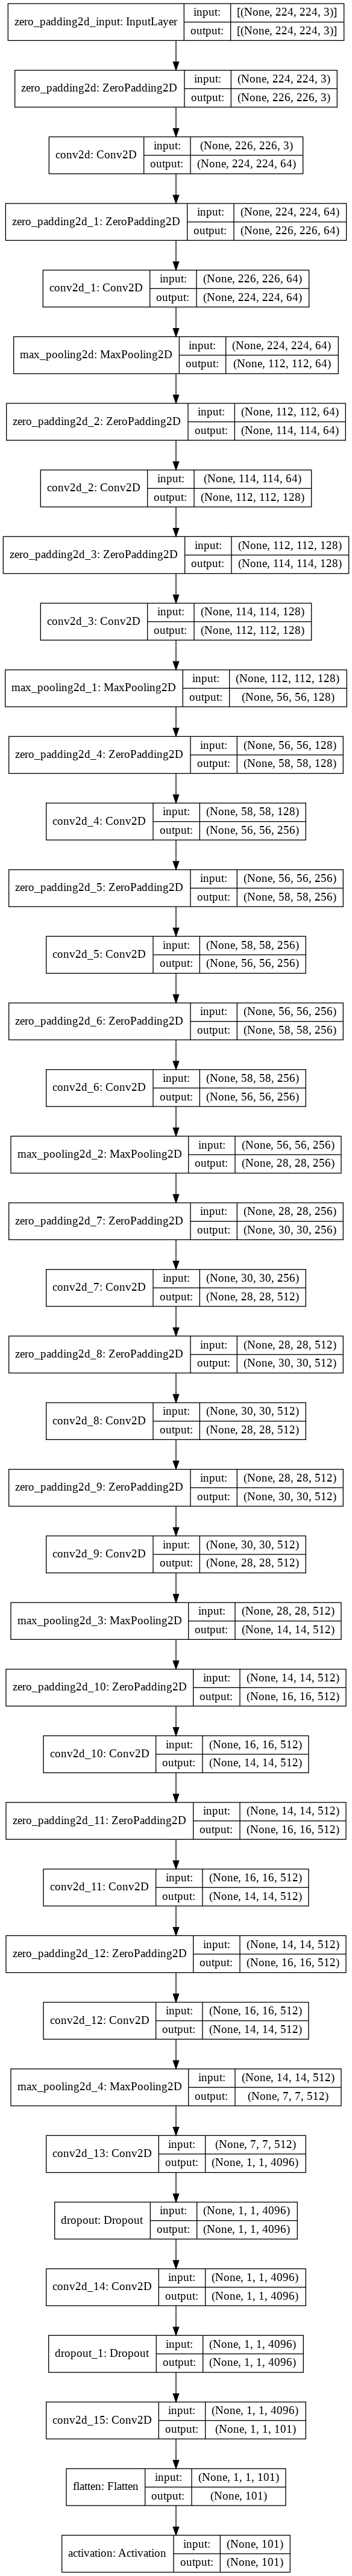

In [27]:
# show model summary
age_model.summary()


# display model structure
plot_model(age_model, 'age_model.png', show_shapes=True)

AGE MODEL TRAINING

In [28]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_acc', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('age_model_weights.h5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

In [ ]:
# train age model
history = age_model.fit(age_train, epochs= 100,
                    steps_per_epoch = len(train_data)// BATCH_SIZE,
                    validation_data = age_val, 
                    validation_steps = len(val_data)//BATCH_SIZE,
                    callbacks= [reduceLR, early_stopping, checkpoint])

Epoch 1/100
708/708 [==============================] - 2723s 4s/step - loss: 4.4516 - acc: 0.0269 - val_loss: 4.3815 - val_acc: 0.0266

Epoch 00001: val_loss improved from inf to 4.38150, saving model to age_model.weights.hdf5
Epoch 2/100
708/708 [==============================] - 2583s 4s/step - loss: 3.9246 - acc: 0.0399 - val_loss: 4.3139 - val_acc: 0.0163

Epoch 00002: val_loss improved from 4.38150 to 4.31390, saving model to age_model.weights.hdf5
Epoch 3/100
708/708 [==============================] - 2515s 4s/step - loss: 3.7325 - acc: 0.0485 - val_loss: 4.7874 - val_acc: 0.0217

Epoch 00003: val_loss did not improve from 4.31390
Epoch 4/100
708/708 [==============================] - 2419s 3s/step - loss: 3.6001 - acc: 0.0546 - val_loss: 4.3259 - val_acc: 0.0316

Epoch 00004: val_loss did not improve from 4.31390
Epoch 5/100
708/708 [==============================] - 2405s 3s/step - loss: 3.5342 - acc: 0.0585 - val_loss: 4.0827 - val_acc: 0.0452

Epoch 00005: val_loss improved f

In [29]:
# # define path for best weights
# age_weights_path= '/content/drive/MyDrive/Colab Notebooks/models/age_model_weights.h5'

In [30]:
# save  best weights
# age_model_weights.save(age_weights_path)

In [31]:
# # load best weights to model
# age_model.load_weights(age_weights_path)

AGE MODEL TESTING

In [ ]:
# evaluate model
# age_model.evaluate(test_datagen)

In [32]:
# load test images
def load_images(series, folder_path):
  features = []
  for  path in series.values:
    image_path = folder_path + path
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, TARGET_SIZE)
    features.append(np.array(resized_image))
  return np.array(features)

In [ ]:
# X_test = load_images(test_data['full_path'], 'wiki_crop/')

In [33]:
# get test set features
X_test = load_images(test_data['full_path'][:5000], 'wiki_crop/')

In [34]:
# normalize test set features
X_test = X_test / 255

In [36]:
# get age test set labels
age_test_y = test_data['age'][:5000]

In [ ]:
# get predicted labels 
y_predicted = age_model.predict(X_test)

### Age prediction is a regression problem that has been attempted as  a classification problem here. I will have to convert the predicted classes to continous values (apparent ages) which would be the output of regression prediction. 

In [36]:
# get index for age labels
output_index = np.arange(101)

In [37]:
# convert dominant predicted classes to apparent ages
predictions = np.sum(y_predicted * output_index, axis = 1)

In [38]:
# convert apparent age predictions to integer values
predictions = predictions.astype(np.int)

In [39]:
# get mean absolute error
mae = mean_absolute_error(age_test_y, predictions)
print('mean absolute error is: ', mae)

mean absolute error is:  6.939


In [41]:
# # save model
# age_model.save('age_model.h5')

In [42]:
# load sample image for testing
def loadImage(filepath):
  'Takes path to image args and returns normalized array of image pixels'
  test_img = image.load_img(filepath, target_size=TARGET_SIZE)
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

In [60]:
# get test image path
img_path = '/content/drive/MyDrive/Colab Notebooks/images/image_of_26_years.jpg'

# get test image
test_image = loadImage(img_path)

In [61]:
# get test image prediction
test_pred = age_model.predict(test_image)

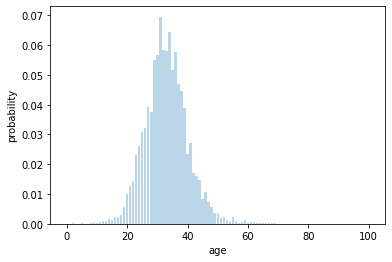

In [62]:
# display test prediction class probality
plt.bar(output_index,test_pred[0], align='center', alpha=0.3)
plt.ylabel('probability')
plt.xlabel('age')
plt.show()

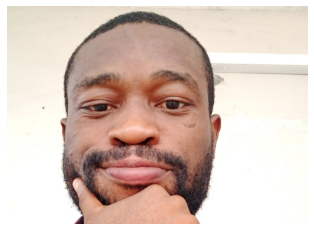

Real age:  26 
 dominant age class : 31 
 apparent age: [33.]


In [64]:
# display image
img = image.load_img(img_path)
plt.imshow(img)
plt.axis(False)
real_age  = 26
dominat_class =  np.argmax(test_pred)
apparent_age = np.round(np.sum(test_pred * output_index, axis = 1))
plt.show()
print("Real age:  {0} \n dominant age class : {1} \n apparent age: {2}".format(real_age, dominat_class, apparent_age))

In [ ]:
GENDER MODEL BUILDING

In [7]:
# build gender model
def build_model():
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(2, (1, 1)))
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

In [8]:
# initialize gender model
gender_model = build_model()

In [10]:
adam = keras.optimizers.Adam(learning_rate=0.0001)

# compile model
gender_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_13 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)    

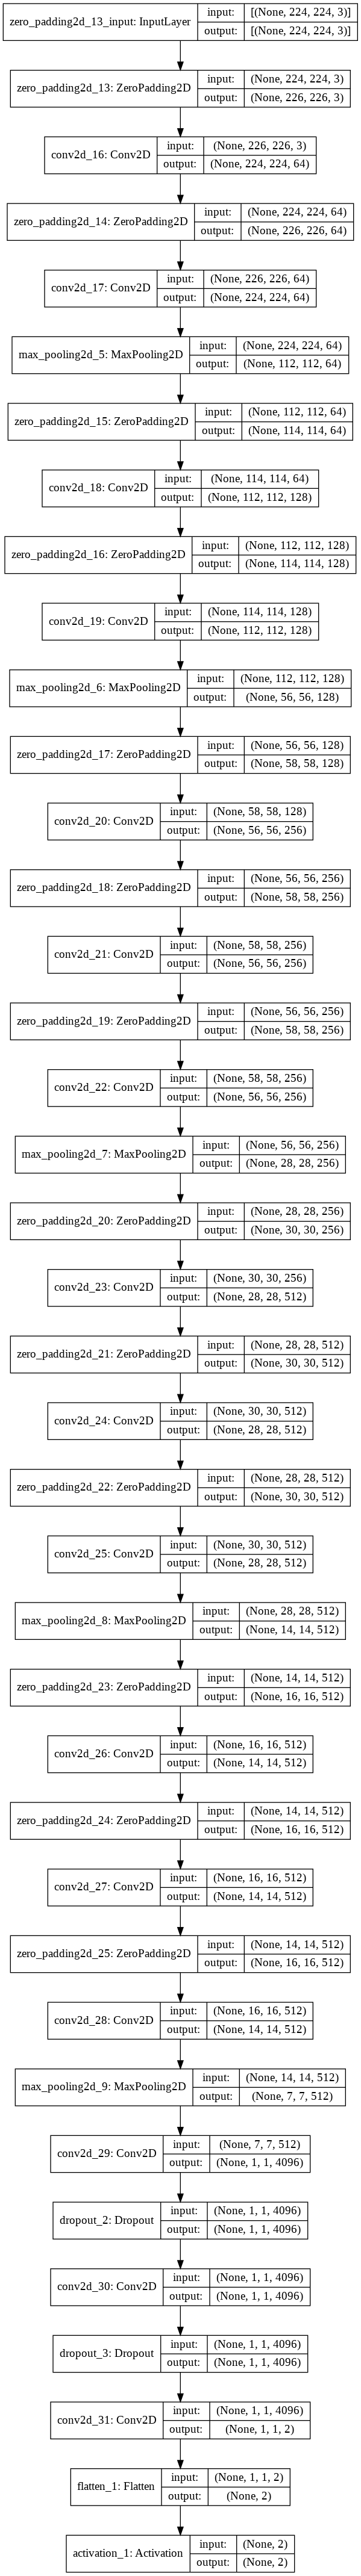

In [69]:
# show model summary
gender_model.summary()

# display model structure
plot_model(gender_model, '/content/drive/MyDrive/Colab Notebooks/models/gender_model.png', show_shapes=True)

GENDER MODEL TRAINING

In [70]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_acc', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('gender_model_weights.h5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

In [ ]:
# train model
history = gender_model.fit(gender_train, epochs= 100,
                    steps_per_epoch = len(train_data)// BATCH_SIZE,
                    validation_data = gender_train, 
                    validation_steps = len(val_data)//BATCH_SIZE,
                    callbacks= [reduceLR, early_stopping, checkpoint])

Epoch 1/100


In [11]:
# # define path for best weights
# gender_weight_path= '/content/drive/MyDrive/Colab Notebooks/models/gender_model_weights.h5'

In [ ]:
# save  best weights
# gender_model_weights.save(gender_model_path)

In [12]:
# # load best weights to model
# gender_model.load_weights(gender_weight_path)

GENDER MODEL TESTING

In [ ]:
# evaluate model
# gender_model.evaluate(gender_train)

In [73]:
# # get gender test set label 
gender_test_y = np.array(test_data['gender'][:5000]).astype(np.int)

In [74]:
# show first 10 gender labels
gender_test_y[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [75]:
# get predicted gender labels 
y_predicted = np.argmax(gender_model.predict(X_test), axis=1)

In [76]:
# show first 10 gender labels
y_predicted[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [77]:
# get moodel accuracy
accuracy = accuracy_score(gender_test_y, y_predicted)
print('accuracy is {}%'.format(round(accuracy * 100)))

accuracy is 96%


In [13]:
# # save model
# gender_model.save('gender_model.h5')

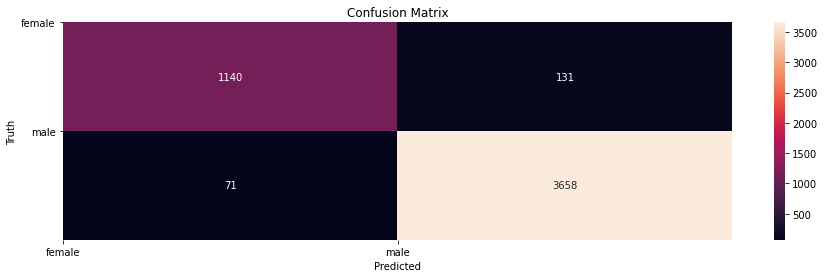

In [80]:
# visualize confusion matrix

plt.figure(figsize=(15,4))
cm = confusion_matrix(gender_test_y, y_predicted)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title ('Confusion Matrix')

classes = gender_dict.values()
tick_marks = np.arange(gender_CLASSES)
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes, rotation=0)
plt.show()

In [81]:
# display classification report
print(classification_report(gender_test_y, y_predicted, target_names= classes))

              precision    recall  f1-score   support

      female       0.94      0.90      0.92      1271
        male       0.97      0.98      0.97      3729

    accuracy                           0.96      5000
   macro avg       0.95      0.94      0.95      5000
weighted avg       0.96      0.96      0.96      5000



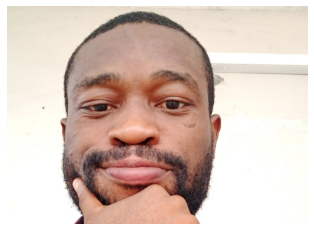

gender:  male


In [82]:
# display test image
plt.imshow(img)
plt.axis(False)
plt.show()

# get test image prediction
test_pred = np.argmax(gender_model.predict(test_image))

# get predicted label name
test_pred = gender_dict[str(test_pred)]

# show test image predicted label 
print('gender: ', test_pred)